<a href="https://colab.research.google.com/github/ValentinVignal/HDStyleTransfert/blob/master/usable_multiple_style_transfert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HD Style Transfert

## Utilisation

1. Create 2 folders on your computers named *content* and *style*
2. Put the corresponding images in it
3. Create 2 `.zip` files : `content.zip` and `style.zip`
4. Import them in the session (column on the left)
5. Run everything



## What it does

It does all the combinaison of the content and style files and do the style transfert. It saves everything in the folder *results* with the architecture:
```bash
results/
 |- content_image_name1/
 |  |- style_image_name1/
 |  |  |- n_step.png          # The style transfered image at the step n
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- style_image_name2/
 |  |  |- n_step.png
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- ...
 |- content_image_name2/
 |  |- style_image_name1/
 |  |  |- n_step.png
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- style_image_name2/
 |  |  |- n_step.png
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- ...
 |- ...

```

## To keep environment connected

1. Press `Ctrl` + ` Shift` + `i`
2. Go to *Console*
3. Paste these lines:
  ```javascript
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-toolbar-button#connect").click() 
  }
  setInterval(ClickConnect,60000)
  ```
4. Press `Enter`

# Parameters

In [0]:
# All the parameters
class Parameters:
  def __init__(self):
    self.style_weight = 1e-2      # Importance of the style
    self.content_weight = 1e5     # Importance of the content
    self.total_variation_weight = 1e3    # How much to reduce high frequencies

    self.ratio_weight = 1e2     # Reduction of smaller sub-images
    
    self.epochs = 5
    self.steps_per_epoch = 5
    self.lr = 1e-2

    self.style_division = False     # Should we use sub-images of the style image

P = Parameters()

resultats OK:
```python
style_weight = 1e-1
content_weight = 1e3
total_variation_weight = 1e4

ratio_weight = 1e2

epochs = 10
steps_per_epoch = 20

style_division = True
```
```python
style_weight = 1e-1
content_weight = 1e5
total_variation_weight = 5e3

ratio_weight = 1e2

epochs = 10
steps_per_epoch = 10

style_division = False
```

# Setup


## Import and configure modules

In [0]:
#!rm -r content results style results.zip

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [6]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.test.gpu_device_name())
print('tf version', tf.__version__)

/device:GPU:0
tf version 2.1.0


In [0]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import random

import os
from pathlib import Path

from google.colab import files
from zipfile import ZipFile
import zipfile
import gc

In [0]:
def tensor_to_image(tensor):
  """
  take a tensor with 0 <= values <= 1 and return the corresponding image
  """
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)


## Progress Bar

In [0]:
########## Definition of a class creating a progress bar ##########
class ProgressBar():
  """
  ProgressBar
  """
  def __init__(self, max_iteration=100, toolbar_width=95, iteration=0, title=''):
    self.iteration = iteration
    self.max_iteration = max_iteration
    self.toolbar_width = toolbar_width
    self.title = title
    if self.title != '':
      display.display(display.HTML(
          """
          <p>
          {0} :
          </p>
          """.format(self.title)
        ),
        display_id=True
      )
    self.out = display.display(self.progress(0, self.max_iteration, self.toolbar_width), display_id=True)
    
  def progress(self, iteration, max, width):
    return display.HTML("""
        <div>
        <progress
            value='{0}'
            max='{1}',
            style='width: {2}%; background-color: #eee; border-radius: 2px; box-shadow: 0 2px 5px rgba(0, 0, 0, 0.25) inset;'
        >
            {0}
        </progress>
        <p>
        {3}%
        </p>
        </div>
      """.format(iteration, max, width, iteration * 100 / max))
  
  def update(self, iteration=None):
    if iteration is None:
      iteration = self.iteration + 1
    self.iteration = iteration
    self.out.update(self.progress(self.iteration, self.max_iteration, self.toolbar_width))

## Global Variables

In [0]:
class GlobalVariables:
  """
  All the Global variables
  """
  def __init__(self):
    self.img_size_nn = 512    # Max size as an input in the neural network
    self.img_size_hd = 2048   # TODO: change it to 4096
    self.ratio_size = self.img_size_hd // self.img_size_nn    # the ratio >= 1
    # self.nb_subimages_per_dim = P.nb_offsets * (self.ratio_size - 1) + 1
    self.real_shape_nn_content = None   # Shape of the content image given to the neural network
    self.real_shape_hd_content = None   # Shape of the real content image
    self.real_shape_nn_style = None     # Shape of the style image given to the neural network
    self.real_shape_hd_style = None     # Shape of the real style image

    self.nb_offsets = 4

GV = GlobalVariables()

## Images

Download images and choose a style image and a content image:

In [0]:
work_with_labrador = False

if work_with_labrador:
  Path('content').mkdir(exist_ok=True, parents=True)
  Path('style').mkdir(exist_ok=True, parents=True)
  
  content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
  os.rename('/root/.keras/datasets/YellowLabradorLooking_new.jpg', 'content/YellowLabradorLooking_new.jpg')
  
  # https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
  style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
  os.rename('/root/.keras/datasets/kandinsky5.jpg', 'style/kandinsky5.jpg')
else:
  # TODO: unzip the folders
  with ZipFile('content.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
  with ZipFile('style.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

content_path = [Path('content') / f for f in os.listdir('content')]
style_path = [Path('style') / f for f in os.listdir('style')]


### Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [0]:
def load_img(path_to_img, max_dim=GV.img_size_nn):
  """
  arg: path of the image
  return: a tensor of shape (1, h, l, 3)
  """
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)    # (h, l, 3)
  img = tf.image.convert_image_dtype(img, tf.float32)   # (h, l 3)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)   # (512, 512, 3)
  img = img[tf.newaxis, :]    # (1, 512, 512, 3)
  return img

Create a simple function to display an image:

In [0]:
def imshow(image, title=None):
  """
  Show a tensor as an image
  """
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)   # squeeze = remove shape of 1

  plt.imshow(image)
  if title is not None:
    plt.title(title)

In [0]:
def load_content_style_img(content_path, style_path, plot_it=False):
  content_image = load_img(content_path, max_dim=GV.img_size_hd)
  GV.real_shape_hd_content = content_image.shape[1:3]
  GV.real_shape_nn_content = (int(content_image.shape[1] / GV.ratio_size), int(content_image.shape[2] / GV.ratio_size))
  style_image = load_img(style_path, max_dim=GV.img_size_hd)
  GV.real_shape_hd_style = style_image.shape[1:3]
  GV.real_shape_nn_style = (content_image.shape[1] // GV.ratio_size, content_image.shape[2] // GV.ratio_size)
  
  if plot_it:
    plt.subplot(1, 2, 1)
    imshow(content_image, 'Content Image')
    
    plt.subplot(1, 2, 2)
    imshow(style_image, 'Style Image')
  return content_image, style_image

# Model


Load a `VGG19` without the classification head, and list the layer names

In [15]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 3s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


*Outputs :*

```
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
```

Choose intermediate layers from the network to represent the style and content of the image:


In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model 

In [0]:
#@title  { display-mode: "code" }
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

## Gram Matrix

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calcualted for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [0]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [0]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    """Expects float input in [0,1]"""
    inputs = inputs*255.0
    #preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(inputs)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

extractor = StyleContentModel(style_layers=style_layers, content_layers=content_layers)

# Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [0]:
def get_ij(i, j, o_i=0, o_j=0, ratio_size=GV.ratio_size, img_type='content'):
  """
  return i_start, i_stop, j_start, j_stop
  """
  if img_type == 'content':
    shape_hd = GV.real_shape_hd_content
    shape_nn = GV.real_shape_nn_content
  elif img_type == 'style':
    shape_hd = GV.real_shape_hd_style
    shape_nn = GV.real_shape_nn_style
  i_offset = (o_i * shape_hd[0]) // (GV.nb_offsets * ratio_size)
  j_offset = (o_j * shape_hd[1]) // (GV.nb_offsets * ratio_size)

  i_start = i * shape_hd[0] // ratio_size + i_offset
  i_stop = i_start + shape_hd[0] // ratio_size
  j_start = j * shape_hd[1] // ratio_size + j_offset
  j_stop = j_start + shape_hd[1] // ratio_size
  return i_start, i_stop, j_start, j_stop


Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [0]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [0]:
#opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
#opt = tf.optimizers.SGD(learning_rate=0.01)
optimizers = np.ndarray(
    shape=(GV.ratio_size, GV.nb_offsets, GV.nb_offsets),
    dtype=tf.optimizers.Optimizer
)

for r in range(GV.ratio_size):
  for o_i in range(GV.nb_offsets):
    for o_j in range(GV.nb_offsets):
      optimizers[r, o_i, o_j] = tf.optimizers.Adam(learning_rate=P.lr, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [0]:
# TODO
#   Make it work is combinaison of images
def style_content_loss(outputs, content_targets, style_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= P.style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= P.content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

In [24]:
a = list(range(5))
print(a)
random.shuffle(a)
print(a)

[0, 1, 2, 3, 4]
[4, 3, 0, 1, 2]


In [0]:
def total_variation_loss(image, content_targets):
  x_deltas, y_deltas = high_pass_x_y(image, content_targets)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

Now include it in the `train_step` function:

In [0]:
# TODO: maybe create a function which creates this function
def create_train_step():
  @tf.function
  def train_step(image, content_image, style_image):
    for r in range(1, GV.ratio_size + 1):
      offsets_i = list(range(GV.nb_offsets))
      random.shuffle(offsets_i)
      for o_i in offsets_i:
        offsets_j = list(range(GV.nb_offsets))
        random.shuffle(offsets_j)
        for o_j in offsets_j:
          loss = tf.zeros(shape=(1,))
          has_loss = False
          with tf.GradientTape() as tape:
            for i in range(r):
              for j in range(r):
                if (o_i == 0 or i < r - 1) and (o_j == 0 or j < r - 1):
                  has_loss = True
                  i_start, i_stop, j_start, j_stop = get_ij(i, j, o_i, o_j, ratio_size=r, img_type='content')
                  img = image[:, i_start:i_stop, j_start:j_stop]
                  img = tf.image.resize(img, GV.real_shape_nn_content)
                  cont = content_image[:, i_start:i_stop, j_start:j_stop]
                  cont = tf.image.resize(cont, GV.real_shape_nn_content)
    
                  outputs = extractor(img)
                  content_targets = extractor(cont)['content']
    
                  if P.style_division:
                    i_start_style, i_stop_style, j_start_style, j_stop_style = get_ij(i, j, o_i, o_j, ratio_size=r, img_type='style')
                    style = style_image[:, i_start_style:i_stop_style, j_start_style:j_stop_style]
                  else:
                    style = style_image
                  style = tf.image.resize(style, GV.real_shape_nn_style)
                  style_targets = extractor(style)['style']
    
                  loss += style_content_loss(outputs, content_targets, style_targets)
                  loss += P.total_variation_weight * tf.image.total_variation(img)
            loss *= P.ratio_weight ** (1 - r)
    
          if has_loss:
            grad = tape.gradient(
              loss,
              image
            )
            optimizers[r-1, o_i, o_j].apply_gradients([(grad, image)])
            image.assign(clip_0_1(image))
  return train_step  

Function to which creates the style transfered images of the different epochs

In [0]:
def style_transfert(content_path, style_path):
  content_image, style_image = load_content_style_img(content_path.as_posix(), style_path.as_posix(), plot_it=True)
  image = tf.Variable(content_image)

  results_folder = Path('results') / content_path.stem / style_path.stem
  results_folder.mkdir(exist_ok=True, parents=True)
  train_step = create_train_step()

  for n in range(P.epochs):
    pb = ProgressBar(max_iteration= (n+1)*P.steps_per_epoch, title=f'Epoch {n+1}/{P.epochs}')
    for m in range((n + 1) * P.steps_per_epoch):
      train_step(
          image=image,
          content_image=content_image,
          style_image=style_image
      )
      pb.update()
    del pb
    display.clear_output(wait=True)
    display.display(tensor_to_image(image).resize((GV.real_shape_nn_content[1], GV.real_shape_nn_content[0])))
    file_name = results_folder / f'step_{(n+1) * P.steps_per_epoch}.png'
    tensor_to_image(image).save(file_name)
    print(f"Epoch: {n+1}/{P.epochs}")
  del content_image, style_image, image, train_step
  gc.collect()

In [0]:
result_path = Path('results')
result_path.mkdir(exist_ok=True, parents=True)

Do the style transfert for all the combinaison of content images and style images

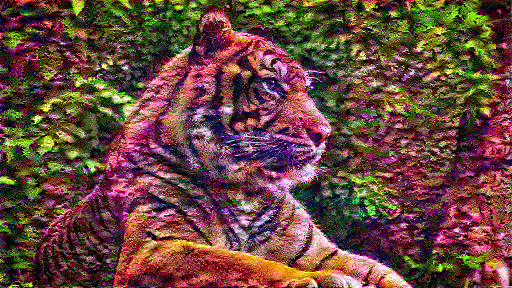

Epoch: 5/5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


ResourceExhaustedError: ignored

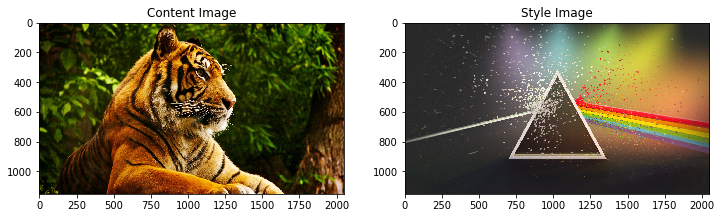

In [29]:
for cp in content_path[1:]:
  for sp in style_path:
    style_transfert(cp, sp)

Zip the results folder and download it

In [0]:
zip_name = 'results.zip'

def zipdir(path, ziph):
  # ziph is zipfile handle
  for root, dirs, files in os.walk(path):
      for file in files:
        ziph.write(os.path.join(root, file))

zipf = zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED)
zipdir('results/', zipf)
zipf.close()

In [0]:
# Download it
is_downloaded = False
while not is_downloaded:
  try:
    files.download(zip_name)
  except:
    pass



In [0]:
! zip -r results.zip results